In [1]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

Using TensorFlow backend.


In [2]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

batch_size = 32

averaging_kernel_weight_9x9 = 1./81
averaging_kernel_weight_5x5 = 1./25
averaging_kernel_weight_3x3 = 1./9

weights_dense = np.load("./weights/weights_dense_64.npy")

In [5]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

train_descrs_dir      = base_dir + '/train'
validation_descrs_dir = base_dir + '/validation'
test_descrs_dir       = base_dir + '/test'

In [6]:
def loading_data(dir_patches, dir_descrs):
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = patch_in[5: 53, 5: 53]
        patch_out = block_reduce(patch_out, (2, 2), func=np.mean)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    
    print("in", patches_in.shape, "  out", patches_out.shape)
    
    return patches_in, patches_out

In [7]:
x_train, y_train = loading_data(train_data_dir, train_descrs_dir)
x_validation, y_validation = loading_data(validation_data_dir, validation_descrs_dir)

in (64598, 56, 56)   out (64598, 24, 24)
in (8075, 56, 56)   out (8075, 24, 24)


In [8]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

x_validation = x_validation.reshape((x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1))
y_validation = y_validation.reshape((y_validation.shape[0], y_validation.shape[1], y_validation.shape[2], 1))
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

(64598, 56, 56, 1) (64598, 24, 24, 1)
(8075, 56, 56, 1) (8075, 24, 24, 1)


In [7]:
# def fixed_generator(x_train, y_train, batch_size):
#     while True:
#         batch_list_x = []
#         batch_list_y = []
        
#         for i in range(x_train.shape[0]):
#             batch_list_x.append(x_train[i])
#             batch_list_y.append(y_train[i])
#             if len(batch_list_x) == batch_size:
#                 yield (np.array(batch_list_x),np.array(batch_list_y))
#                 batch_list_x = []
#                 batch_list_y = []

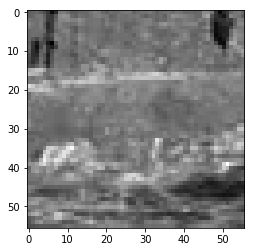

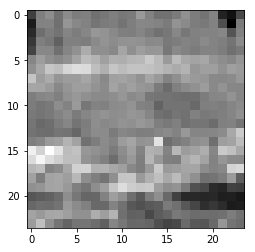

In [9]:
plt.imshow(x_train[3, :, :, 0], cmap='gray')
plt.show()
plt.imshow(y_train[3, :, :, 0], cmap='gray')
plt.show()

In [10]:
input_shape = (input_patch_size, input_patch_size, 1)
input_img = Input(shape=input_shape)

x = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])])(flattened)


x = Dense(1152, activation="relu")(briefed)
x = Reshape((6, 6, 32))(x)

x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)

decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer="adadelta", loss="binary_crossentropy")
brief_ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1180

In [21]:
# model_version_previous = '0.0.3.0.0_decoder128_dense1152_conv32_conv32_up_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output24X24'
# brief_ae_previous = load_model(base_dir + '/brief_ae_' + model_version_previous + '.h5')
# print(brief_ae_previous.get_layer(index=7).get_weights()[0].shape)
# for i in range(7, len(brief_ae.layers)):
#     print(brief_ae_previous.get_layer(index=i))
#     brief_ae.get_layer(index=i).set_weights(brief_ae_previous.get_layer(index=i).get_weights())

In [11]:
brief_ae_previous = load_model('/scratch/image_datasets/2_for_learned_brief/ready/brief_ae_0.0.2.1.1_whole_dense1152_conv32_conv32_up_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output24X24_train50more.h5')
# print(brief_ae_previous.get_layer(index=7).get_weights()[0].shape)
for i in range(len(brief_ae.layers)):
    print(brief_ae_previous.get_layer(index=i))
    brief_ae.get_layer(index=i).set_weights(brief_ae_previous.get_layer(index=i).get_weights())

In [15]:
model_version = '0.4.2.1.1_whole_dense1152_conv32_conv32_up_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output24X24_train50more_imagegen'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history_callback = brief_ae.fit_generator(fixed_generator(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=50,
                validation_data=fixed_generator(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0],
                callbacks=[checkpointer]
                )

brief_ae.save(base_dir + '/brief_ae_' + model_version + '.h5')

# brief_ae = load_model(base_dir + '/brief_ae_' + model_version + '.h5')

Epoch 1/50
125573/125573 [==============================] - 5027s 40ms/step - loss: 0.5789 - val_loss: 0.4620
Epoch 2/50
125573/125573 [==============================] - 5023s 40ms/step - loss: 0.5786 - val_loss: 0.6296
Epoch 3/50
125573/125573 [==============================] - 5012s 40ms/step - loss: 0.5785 - val_loss: 0.6223
Epoch 4/50
125573/125573 [==============================] - 5008s 40ms/step - loss: 0.5784 - val_loss: 0.6178
Epoch 5/50
125573/125573 [==============================] - 4997s 40ms/step - loss: 0.5784 - val_loss: 0.5416
Epoch 6/50
125573/125573 [==============================] - 4997s 40ms/step - loss: 0.5783 - val_loss: 0.5215
Epoch 7/50
125573/125573 [==============================] - 4996s 40ms/step - loss: 0.5782 - val_loss: 0.5817
Epoch 8/50
125573/125573 [==============================] - 4997s 40ms/step - loss: 0.5782 - val_loss: 0.5332
Epoch 9/50
125573/125573 [==============================] - 4988s 40ms/step - loss: 0.5782 - val_loss: 0.6291
Epoch 10/5

In [16]:
history_callback.history

{'val_loss': [0.4619731903076172,
  0.6295711398124695,
  0.6222690939903259,
  0.6178302764892578,
  0.5415879487991333,
  0.5215407609939575,
  0.5817009806632996,
  0.533207893371582,
  0.6290661096572876,
  0.6301108002662659,
  0.5470659732818604,
  0.6490544080734253,
  0.526829183101654,
  0.6137927174568176,
  0.5296748280525208,
  0.5816947221755981,
  0.5441285967826843,
  0.5722288489341736,
  0.6092780232429504,
  0.5895856022834778,
  0.6270440220832825,
  0.620330810546875,
  0.5283738374710083,
  0.5665085315704346,
  0.6027769446372986,
  0.6487970948219299,
  0.43248236179351807,
  0.5202621221542358,
  0.6102949976921082,
  0.5520325899124146,
  0.6091046929359436,
  0.56389981508255,
  0.59141606092453,
  0.5755599737167358,
  0.5963674187660217,
  0.6553992033004761,
  0.5870132446289062,
  0.6102941036224365,
  0.6304003000259399,
  0.586788535118103,
  0.645762026309967,
  0.5528798699378967,
  0.6272500157356262,
  0.5680776238441467,
  0.42823389172554016,
  0.5

predictions: 


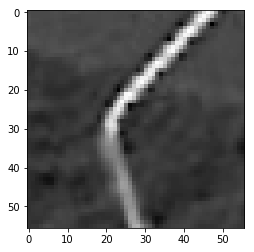

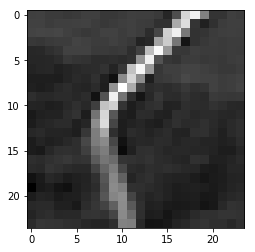

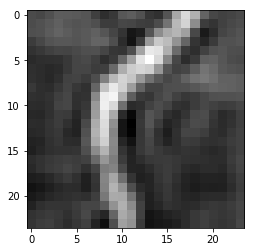

18.28365370631218

 next


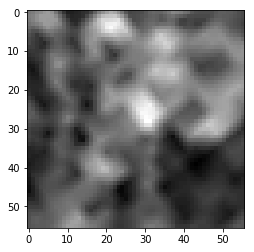

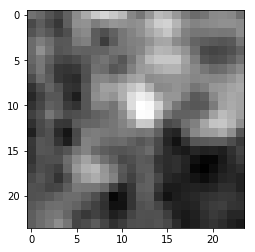

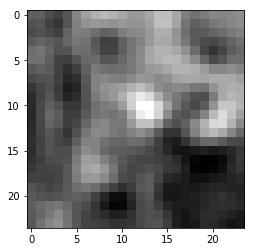

10.308824982494116

 next


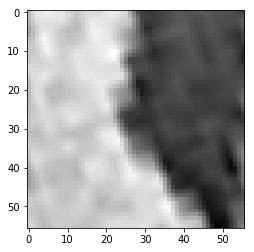

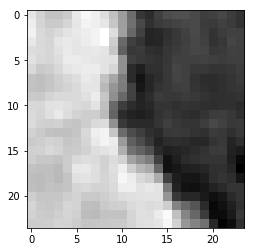

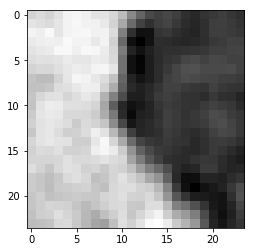

15.633969437330961

 next


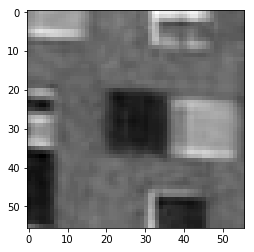

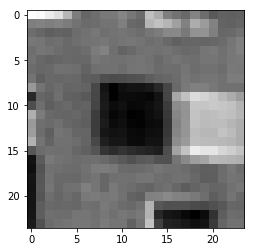

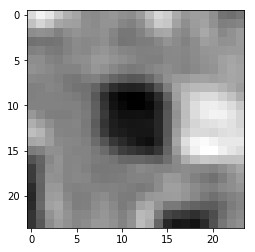

12.0267223007977

 next


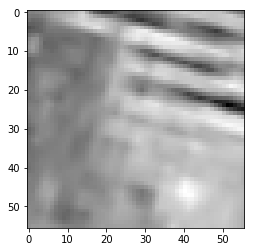

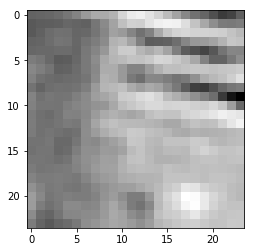

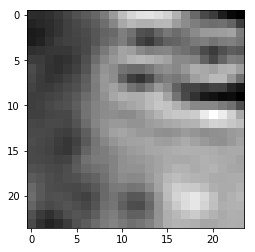

13.064899742603302

 next


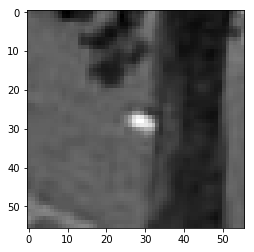

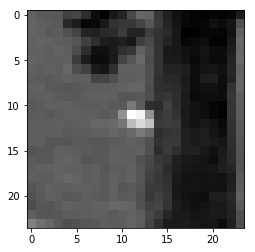

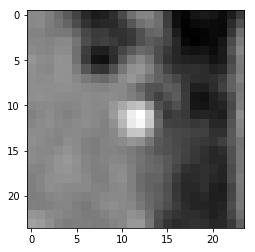

11.715615894645452

 next


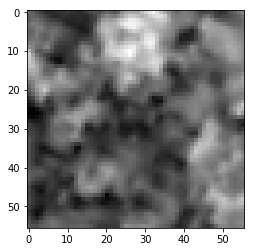

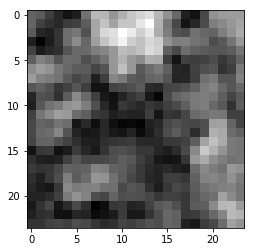

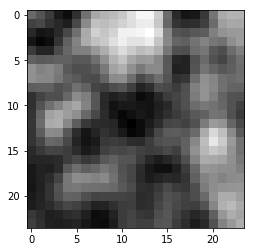

7.540497779846191

 next


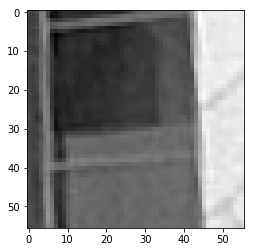

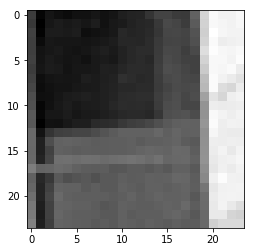

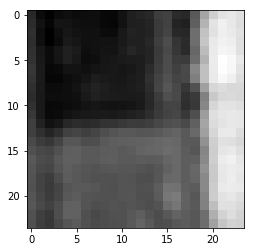

12.175096739083529

 next


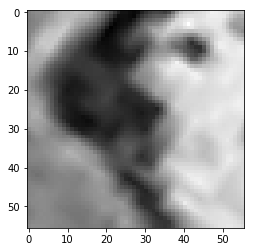

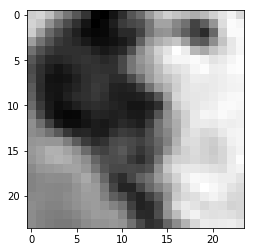

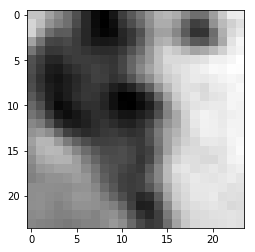

12.635294795036316

 next


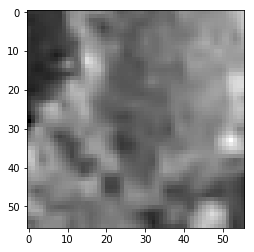

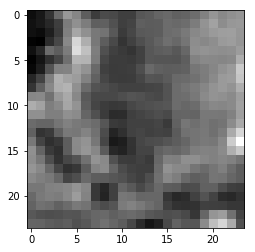

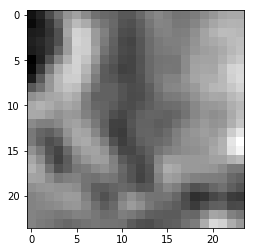

12.017128765583038

 next


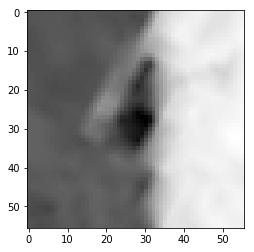

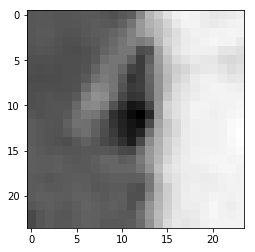

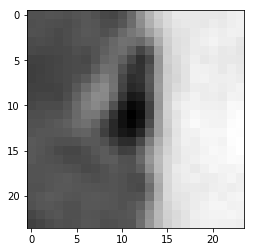

12.01057031750679

 next


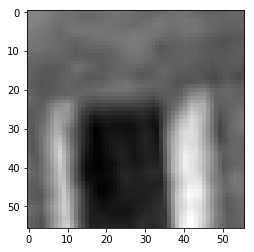

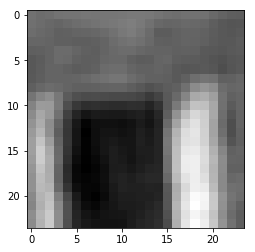

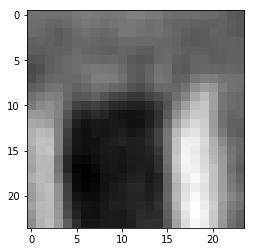

9.044814258813858

 next


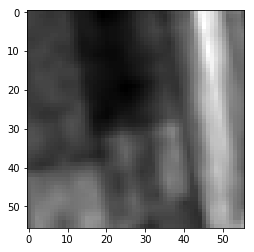

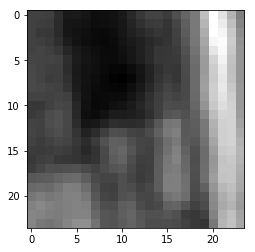

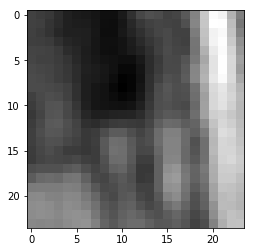

11.690491642802954

 next


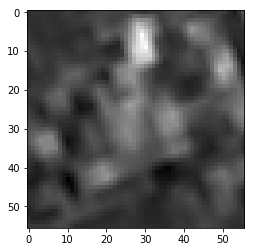

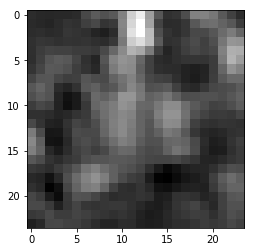

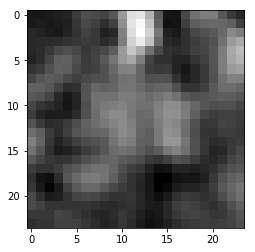

10.464892107993364

 next


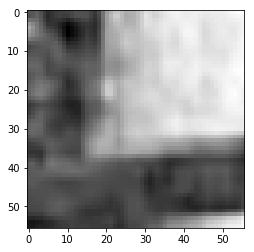

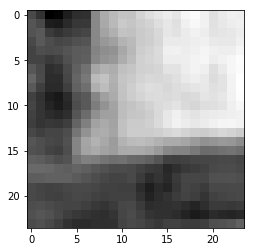

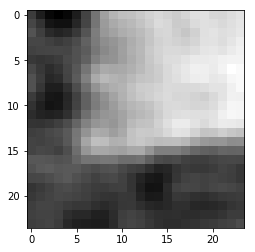

10.01855380833149

 next


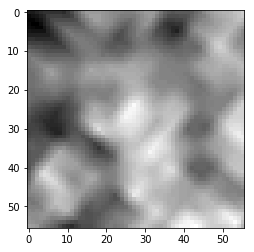

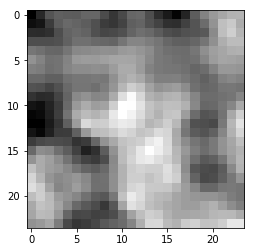

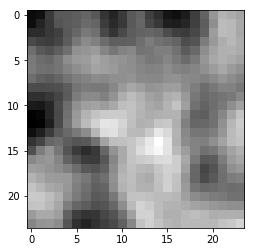

7.935092356055975

 next


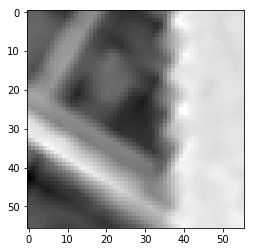

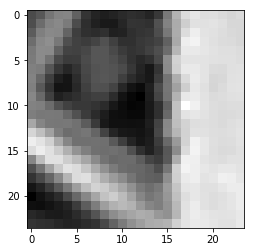

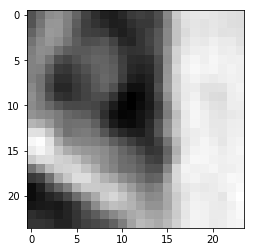

13.436350710690022

 next


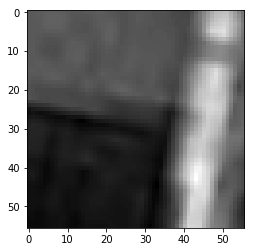

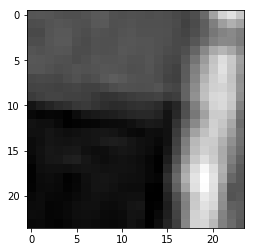

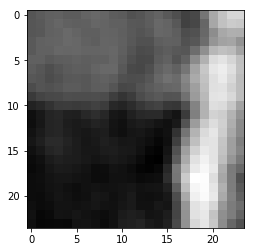

13.149855583906174

 next


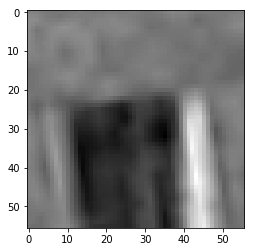

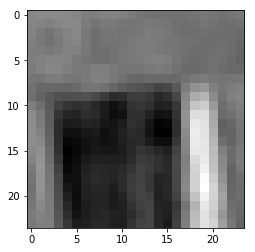

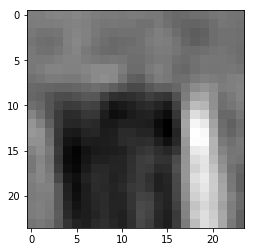

9.1294015198946

 next


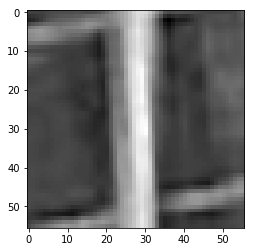

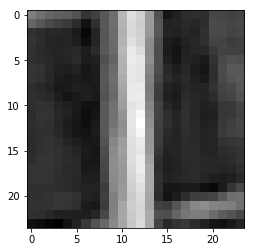

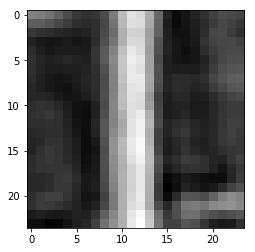

9.619124941527843

 next


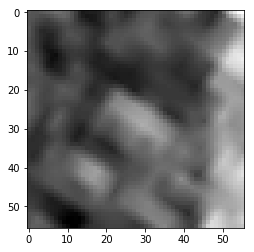

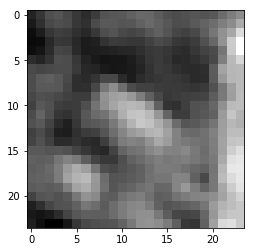

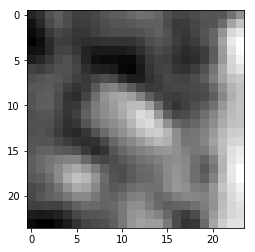

10.586478933691978

 next


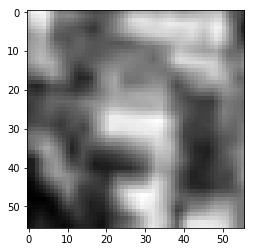

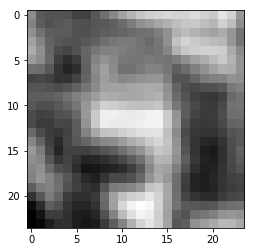

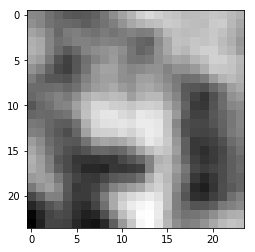

12.113002371042967

 next


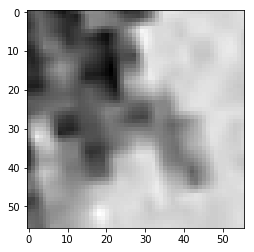

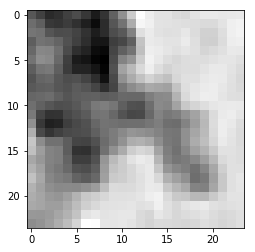

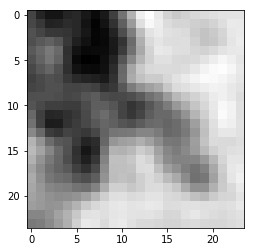

10.278839841485023

 next


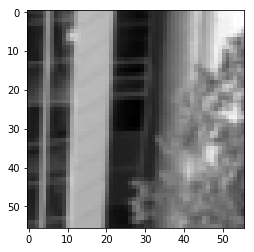

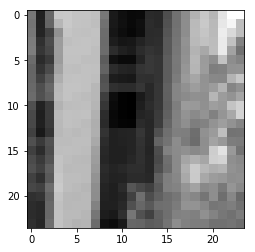

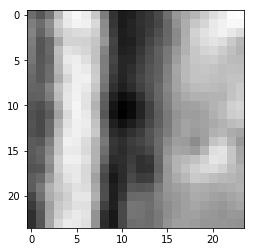

15.233232490718365

 next


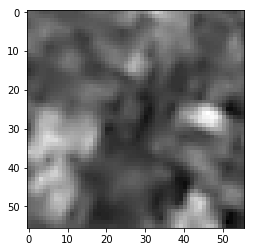

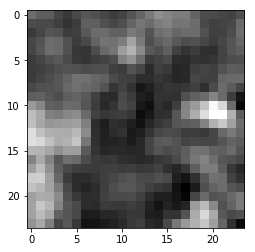

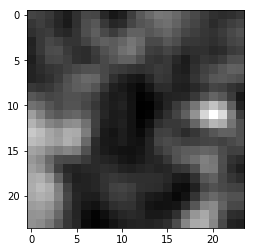

9.875530432909727

 next


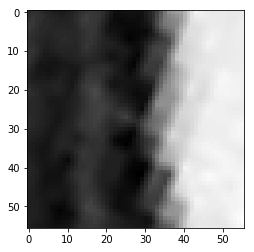

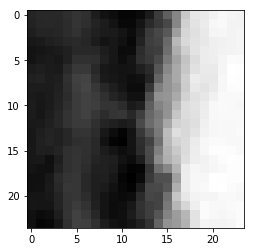

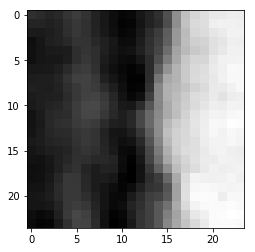

7.358056744560599

 next


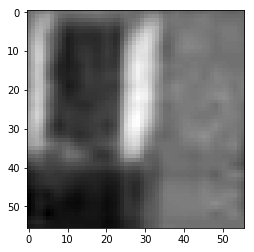

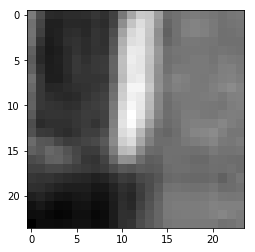

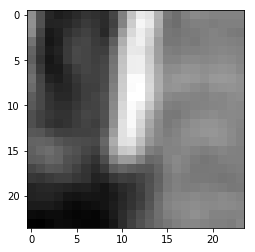

8.594217337667942

 next


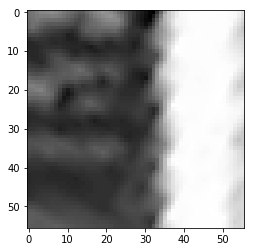

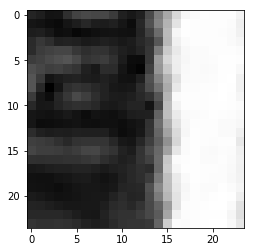

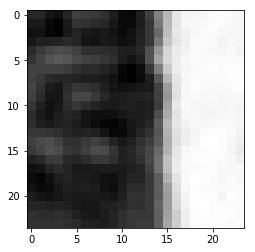

8.243618700653315

 next


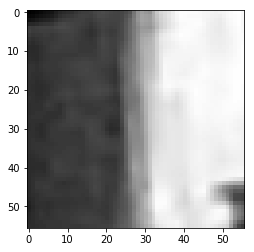

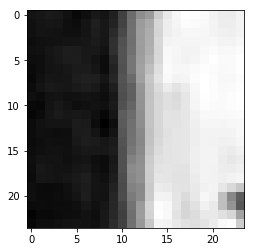

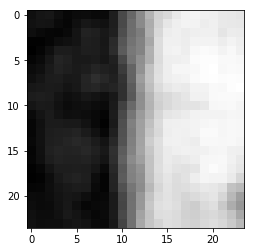

6.007112385705113

 next


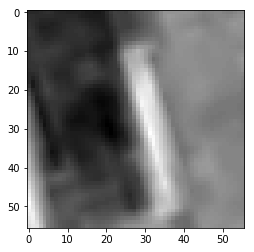

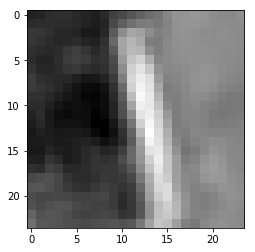

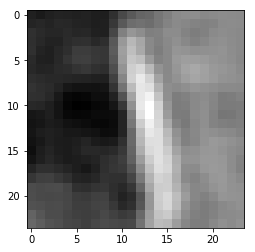

8.414819464087486

 next


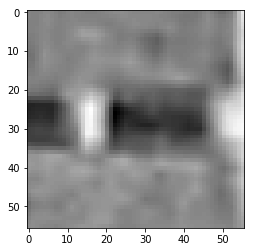

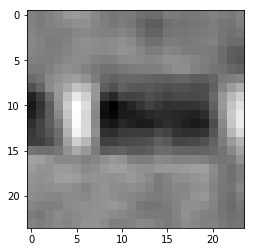

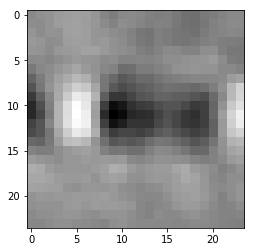

14.38008327037096

 next


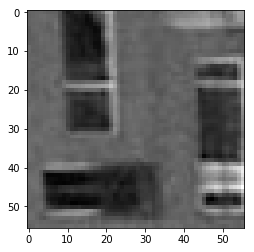

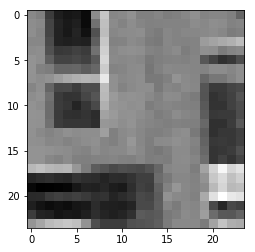

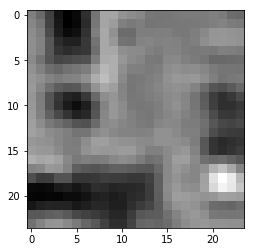

12.604910675436258

 next


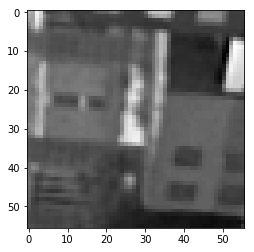

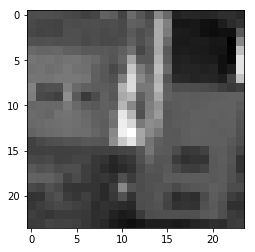

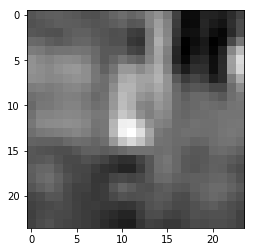

17.412350960075855

 next


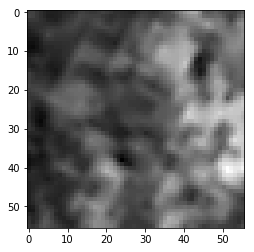

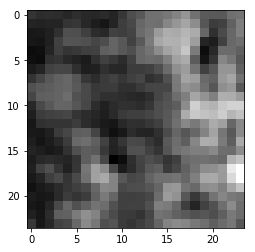

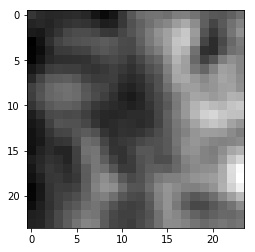

10.363390054553747

 next


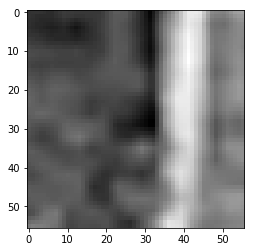

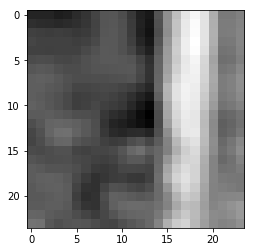

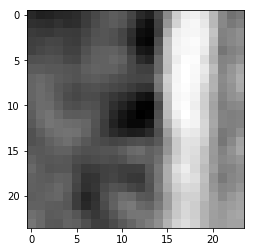

12.806237172335386

 next


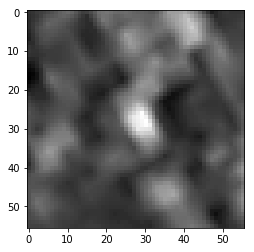

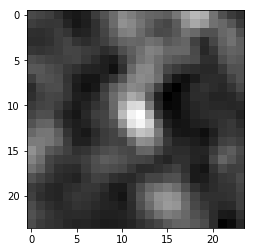

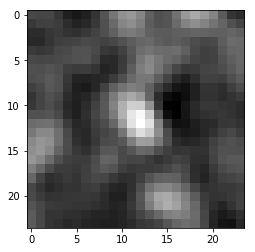

9.158258121460676

 next


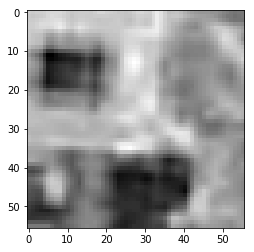

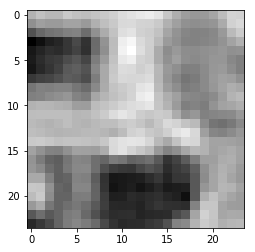

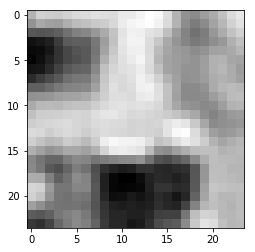

12.933653835207224

 next


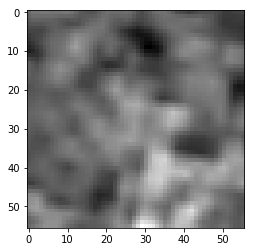

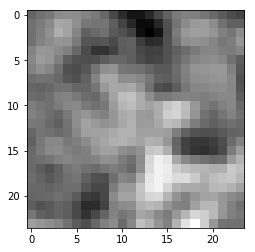

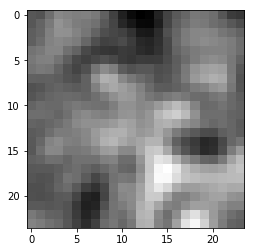

8.703962098807096

 next


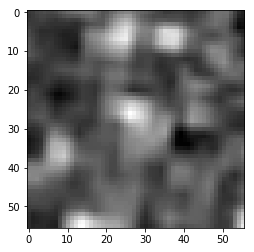

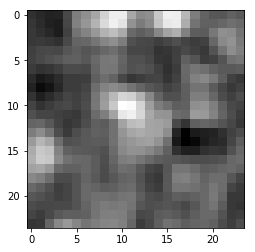

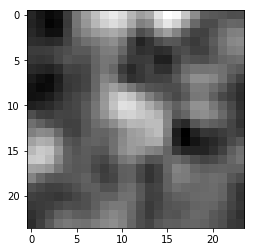

10.2599330060184

 next


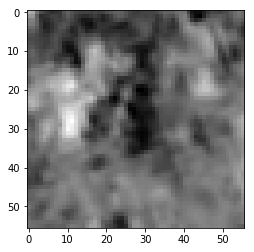

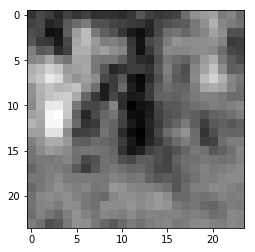

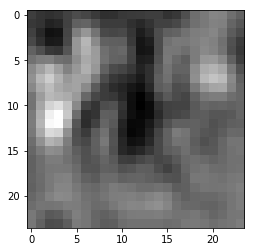

8.687198348343372

 next


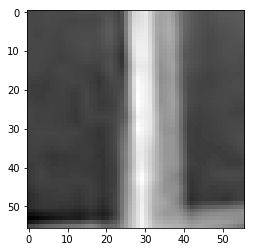

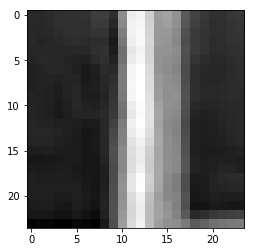

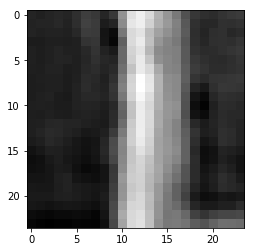

9.694817829877138

 next


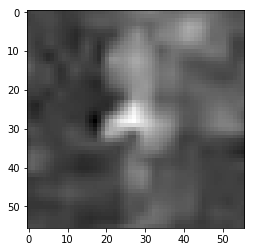

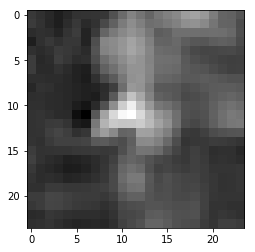

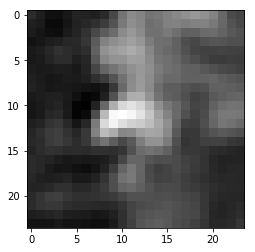

9.251822400838137

 next


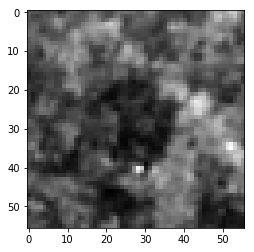

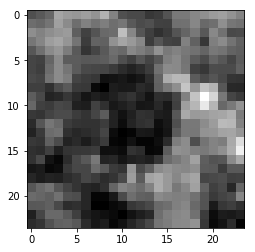

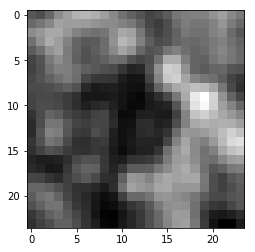

7.454536892473698

 next


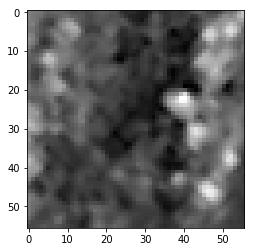

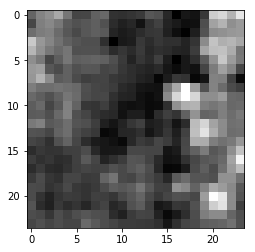

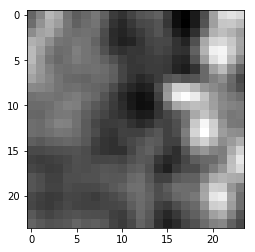

9.517608638852835

 next


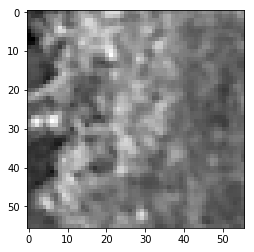

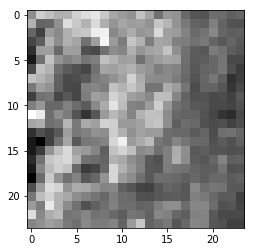

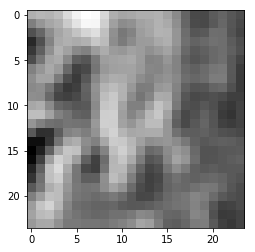

12.801762912422419

 next


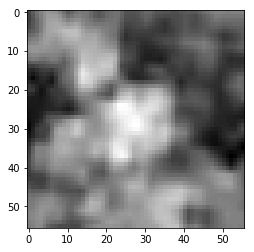

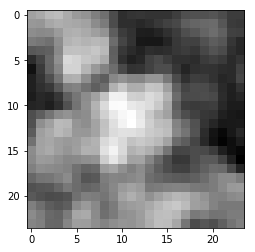

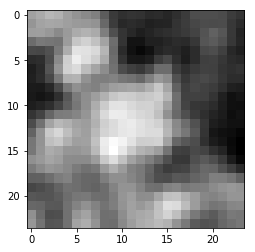

7.397225517779589

 next


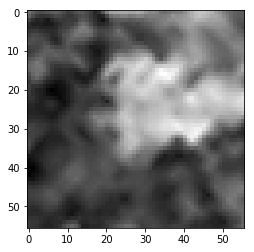

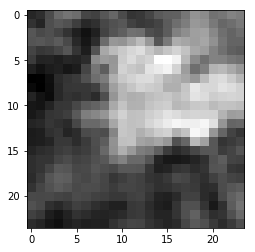

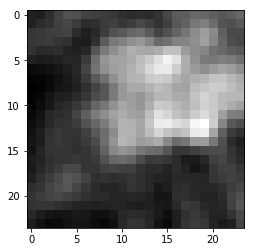

6.319771483540535

 next


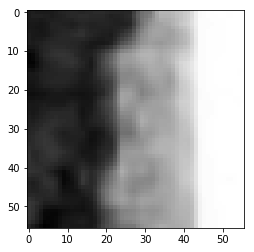

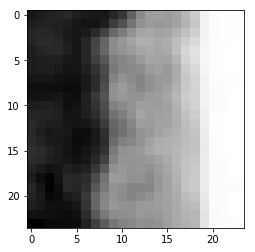

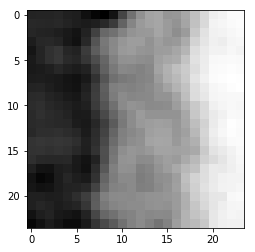

7.691086549311876

 next


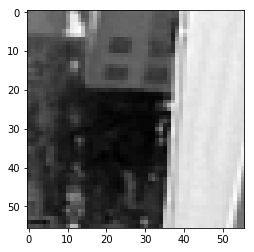

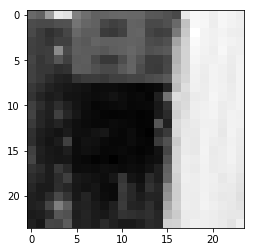

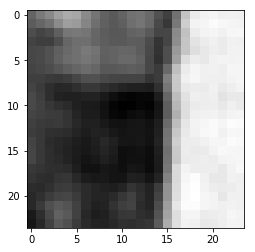

10.640220399945974

 next


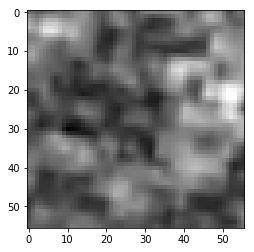

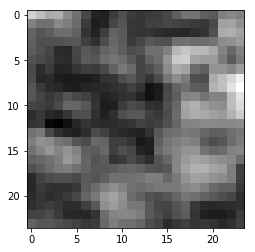

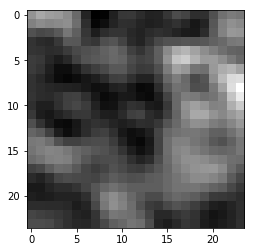

12.75283768773079

 next


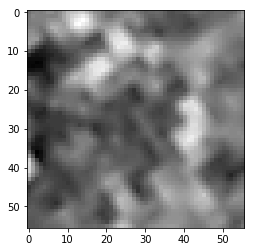

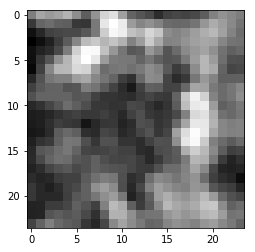

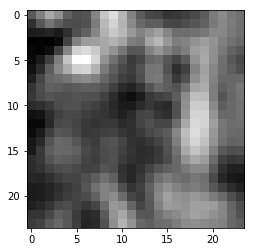

9.901580885052681

 next


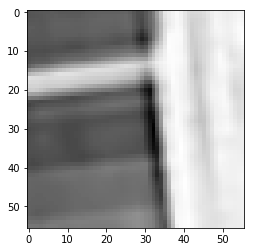

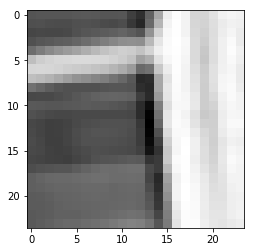

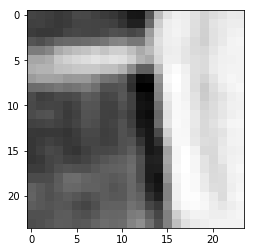

10.999356228858232

 next


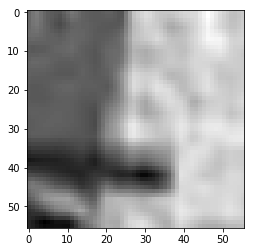

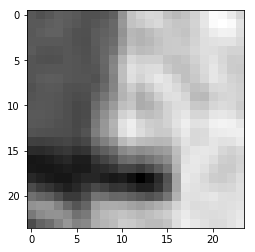

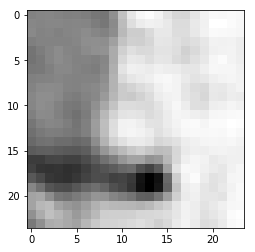

8.52160133421421

 next


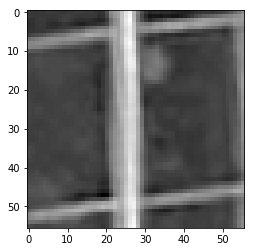

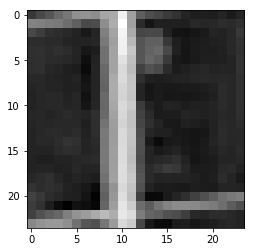

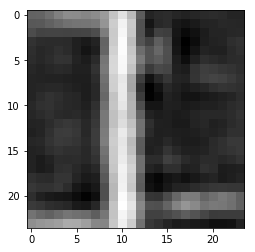

11.920929327607155

 next


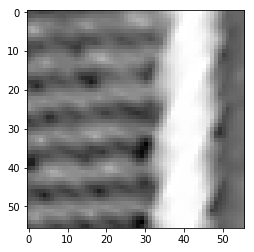

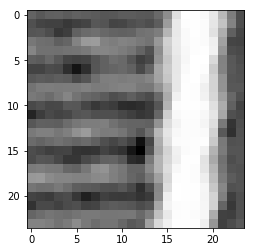

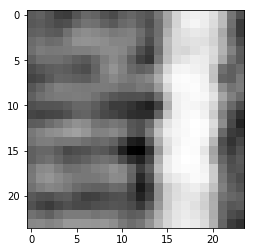

13.324817195534706

 next


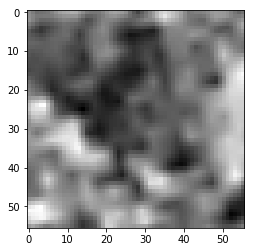

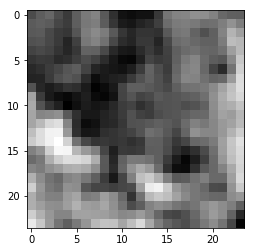

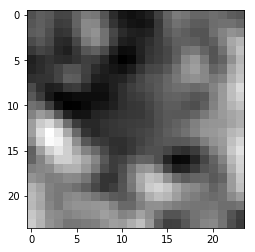

12.9970258846879

 next


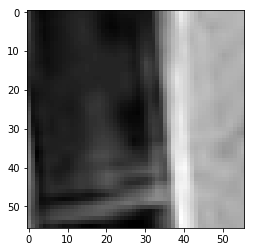

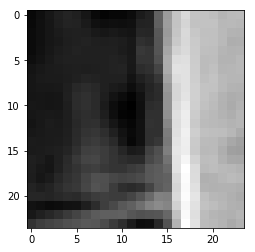

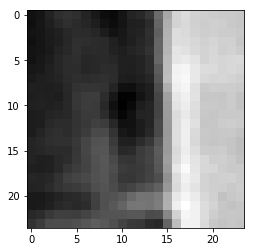

12.05885337665677

 next


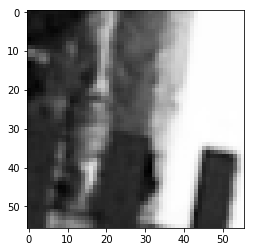

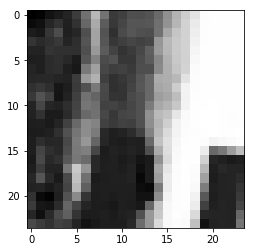

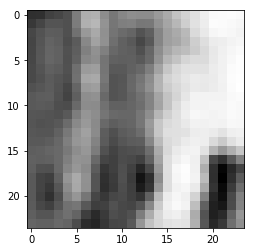

15.840348713099957

 next


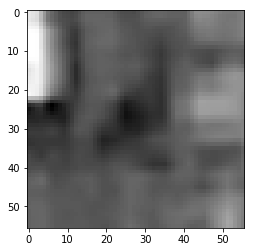

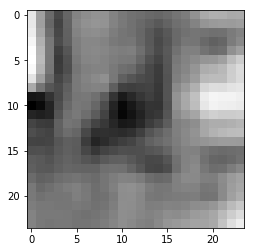

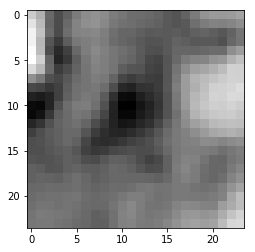

13.167411591857672

 next


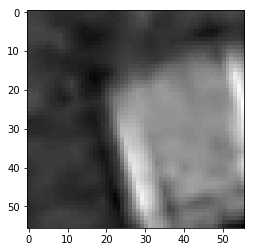

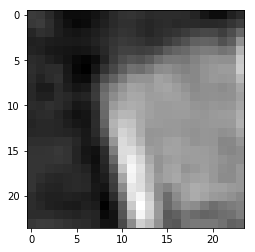

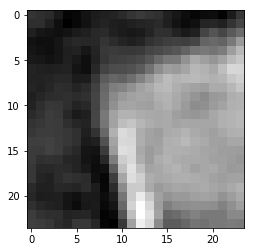

11.76206175237894

 next


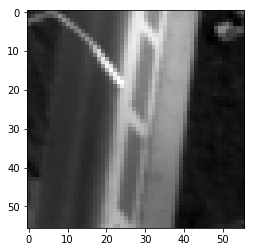

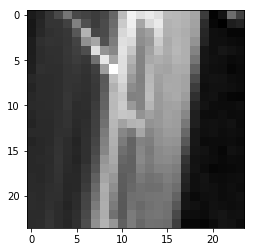

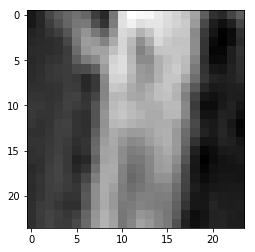

13.1583671271801

 next


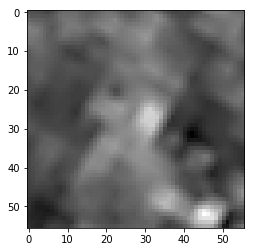

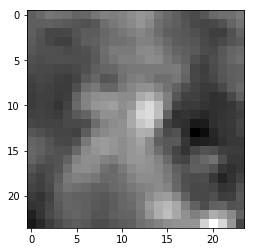

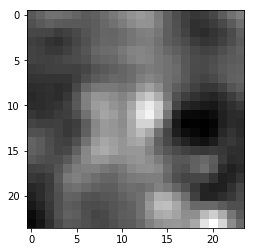

11.60722766071558

 next


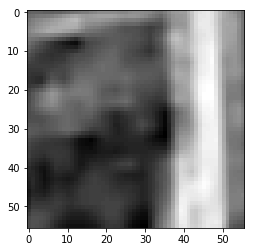

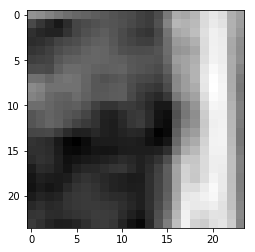

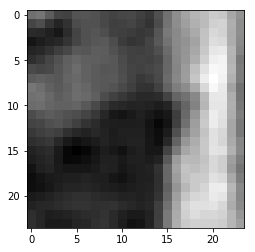

8.723867330700159

 next


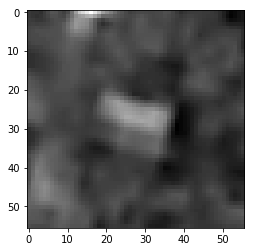

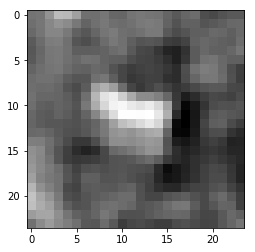

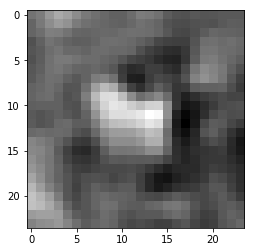

7.555969599634409

 next


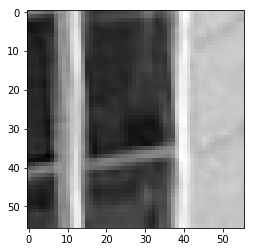

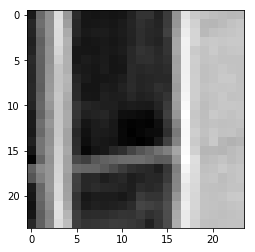

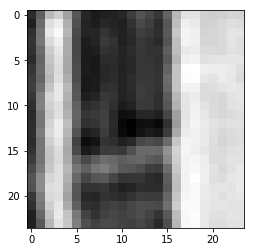

14.319295082241297

 next


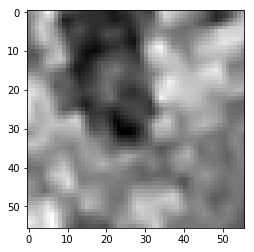

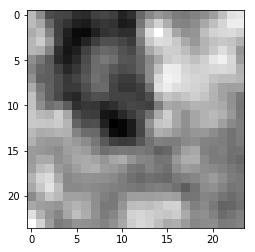

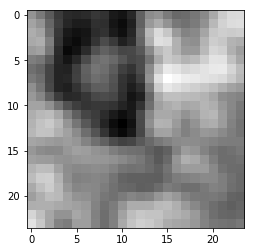

10.343445874750614

 next


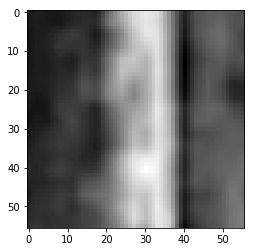

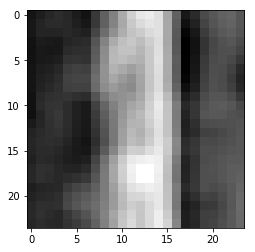

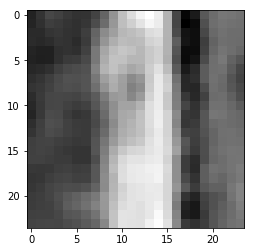

11.396285779774189

 next


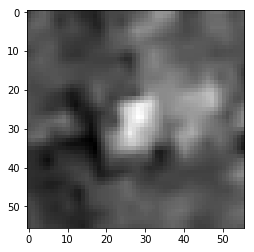

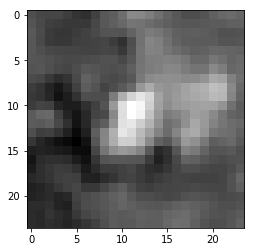

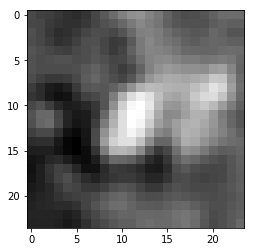

7.889709016308188

 next


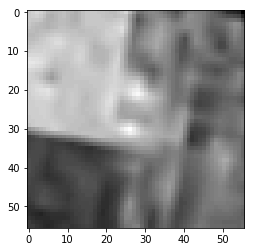

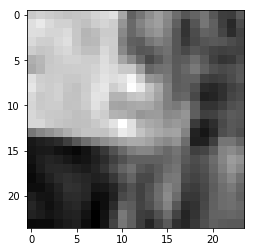

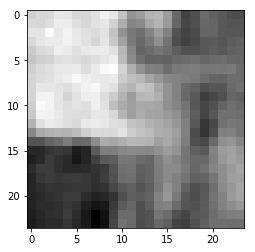

14.05095063149929

 next


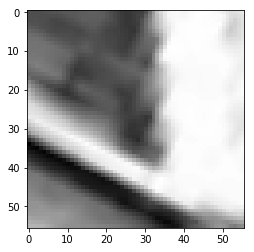

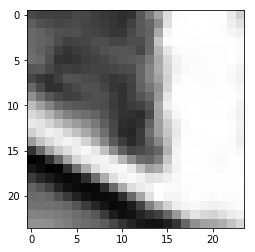

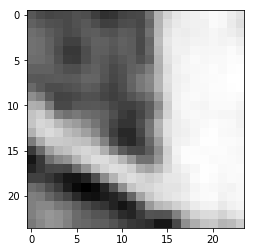

13.975624423474073

 next


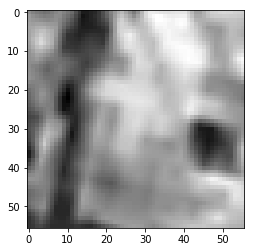

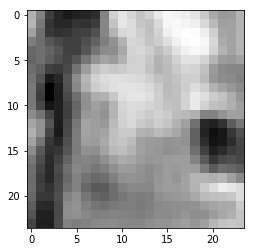

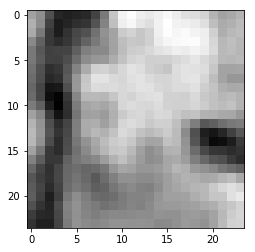

13.888249062001705

 next


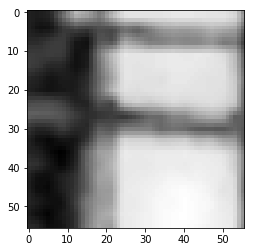

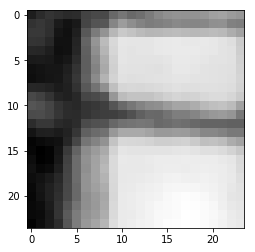

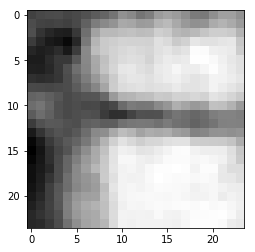

7.470080908387899

 next


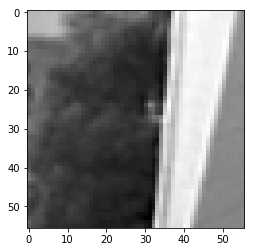

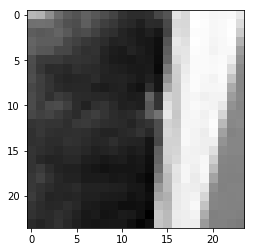

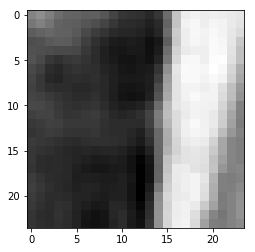

12.616700492799282

 next


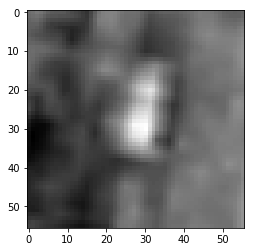

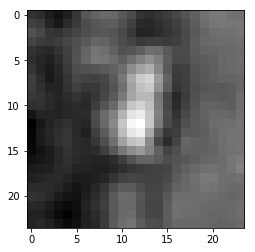

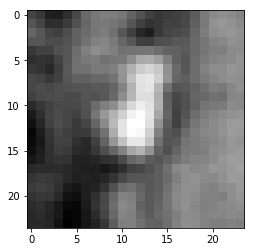

12.648609280586243

 next


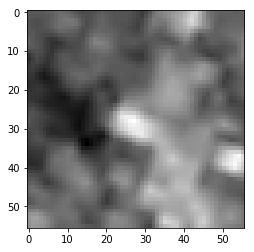

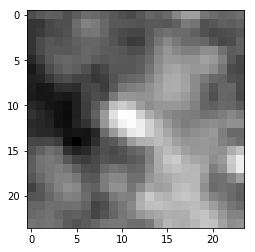

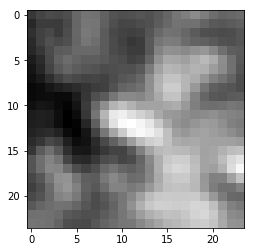

9.36653919517994

 next


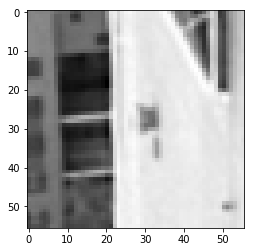

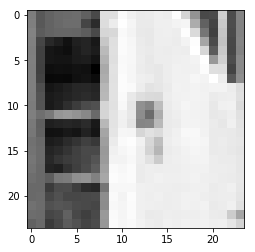

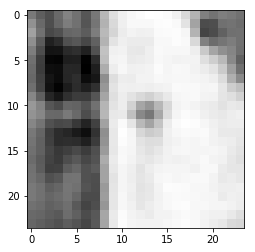

14.368143361061811

 next


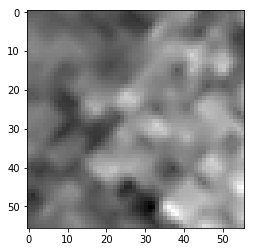

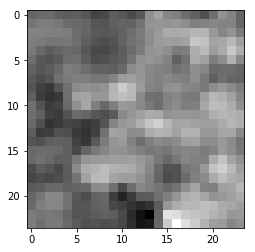

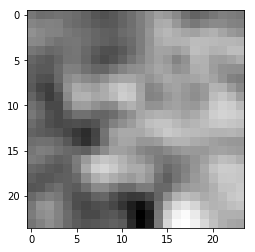

13.282730653882027

 next


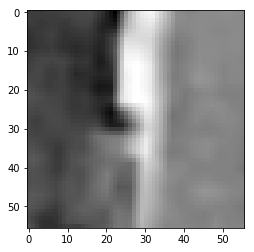

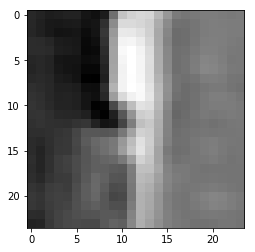

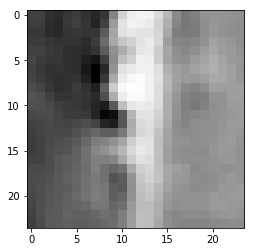

12.977129202336073

 next


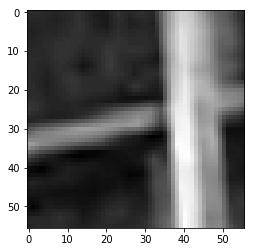

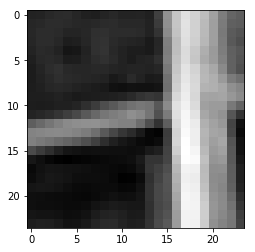

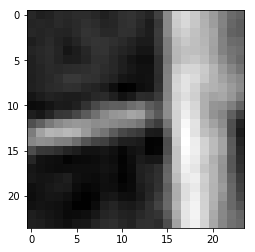

10.734890419989824

 next


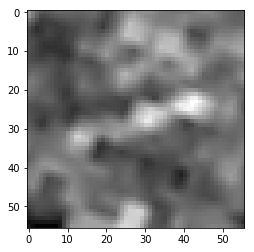

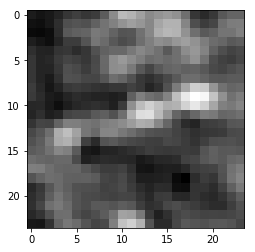

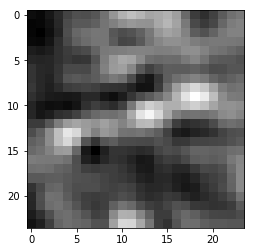

11.245457623153925

 next


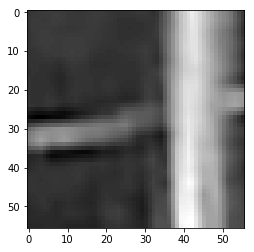

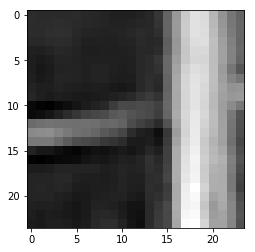

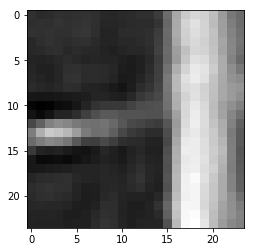

10.74650639668107

 next


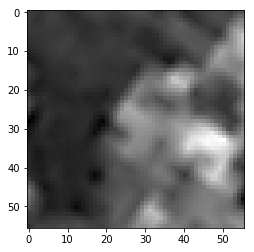

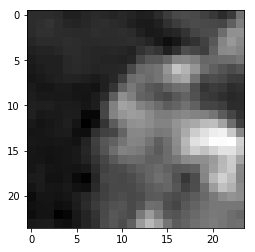

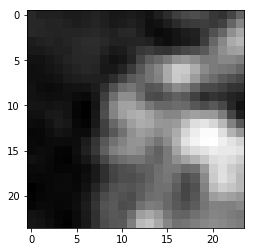

10.823722053319216

 next


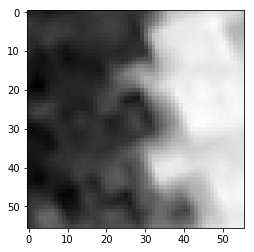

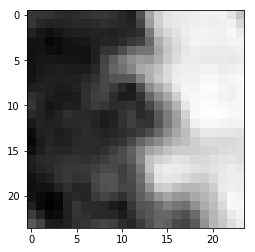

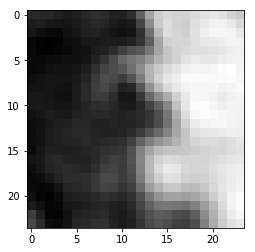

9.33651415631175

 next


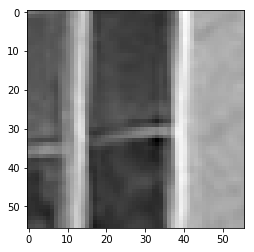

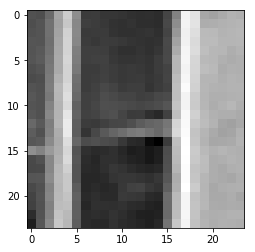

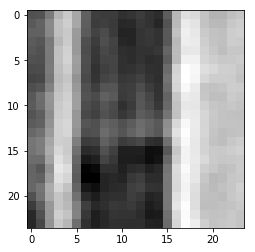

14.101352076977491

 next


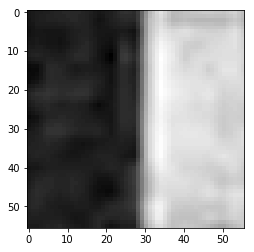

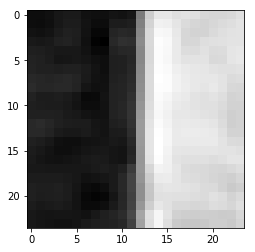

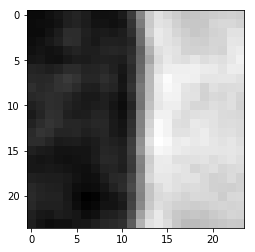

13.09881767258048

 next


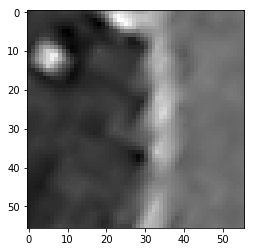

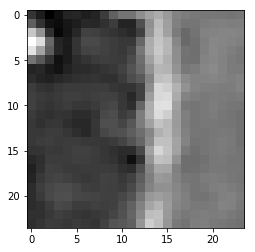

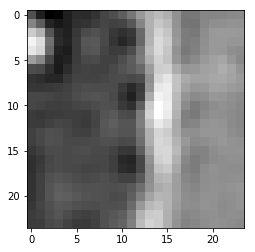

10.699896197766066

 next


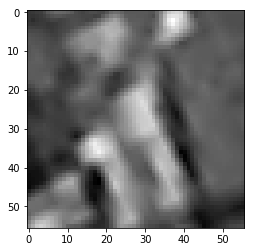

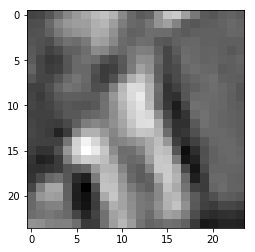

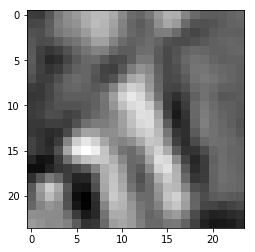

10.281033273786306

 next


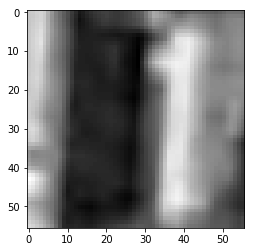

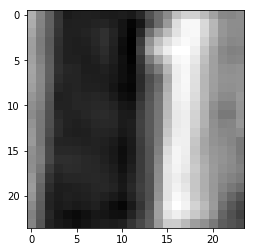

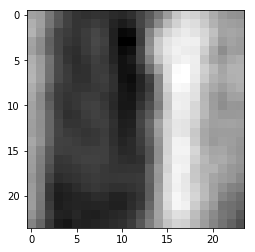

12.951651569455862

 next


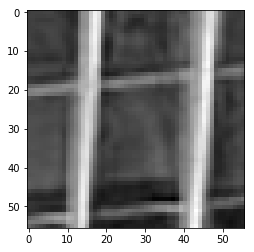

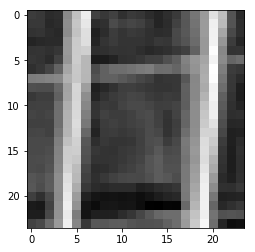

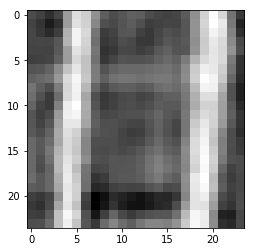

14.718761947005987

 next


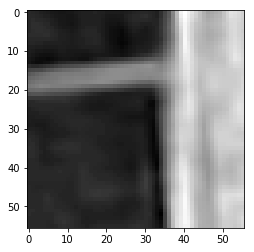

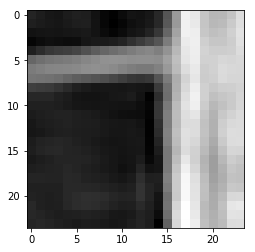

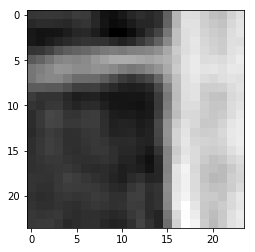

11.184998117387295

 next


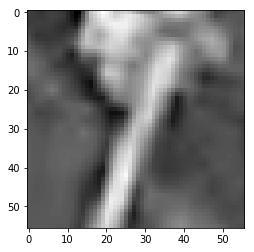

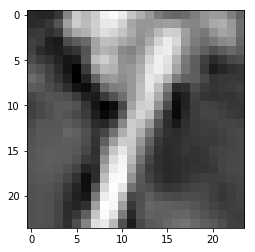

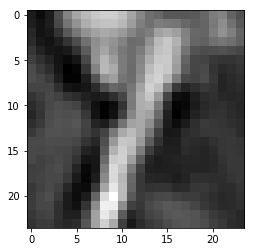

8.61723555251956

 next


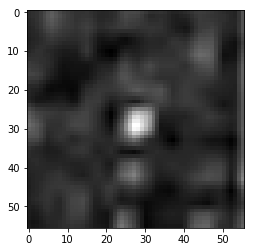

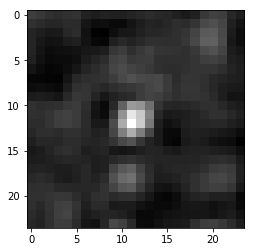

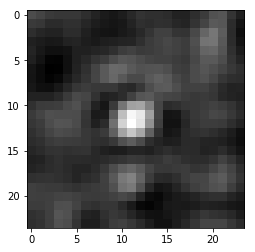

8.007547818124294

 next


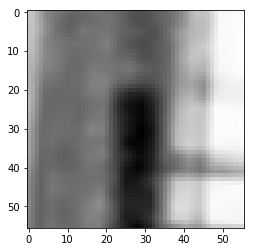

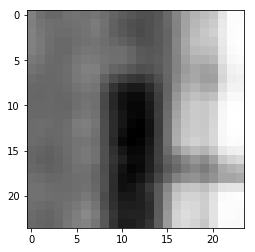

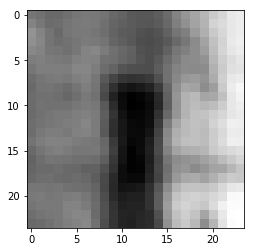

8.376457672566175

 next


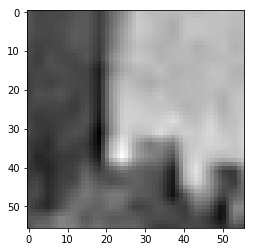

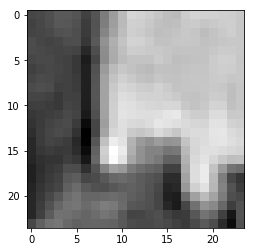

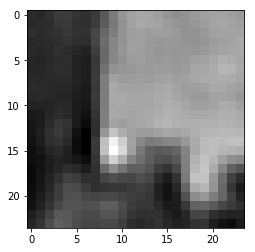

10.830897968262434

 next


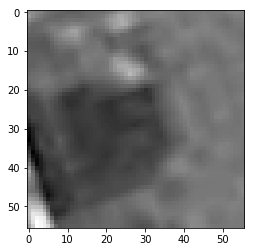

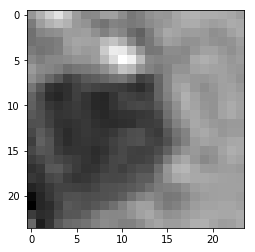

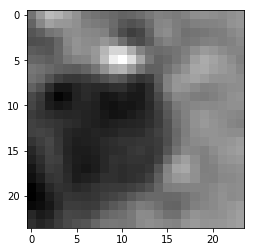

10.47942727804184

 next


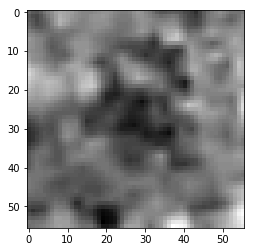

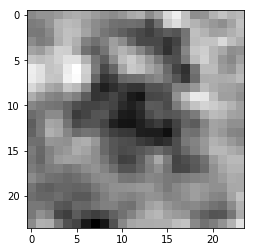

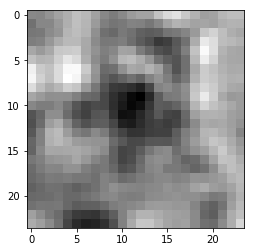

6.836431659758091

 next


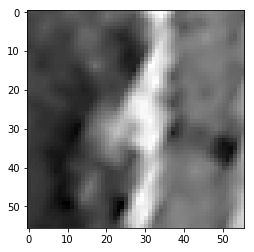

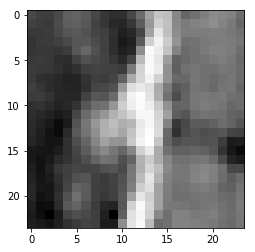

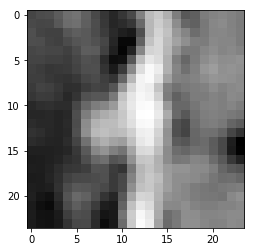

11.975782234221697

 next


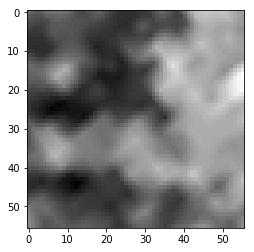

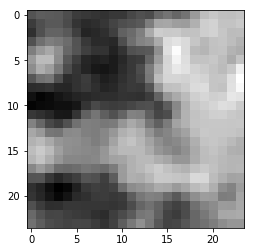

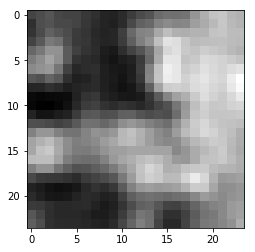

6.098844213411212

 next


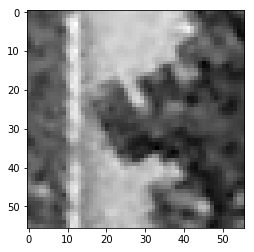

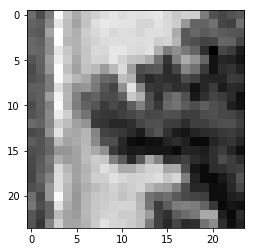

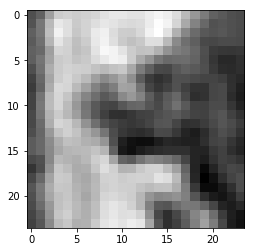

10.593234021216631

 next


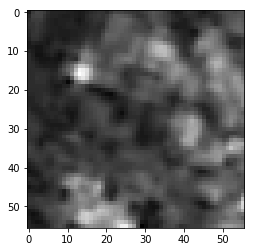

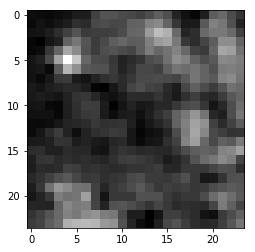

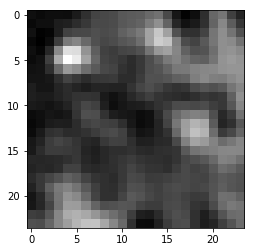

9.30884214118123

 next
0.04316151533275843


In [17]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
    ground_truth = im_1[5: 53, 5: 53, 0]
    ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
    plt.imshow(ground_truth[:, :], cmap='gray')
    plt.show()
    
    
    pred_1 = predictions[i].reshape((24, 24))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(ground_truth, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)

In [18]:
rmses * 255

11.006186409853399

In [23]:
# input_shape_descr = (input_patch_size, input_patch_size, 1)
# input_img_descr = Input(shape=input_shape_descr)

# x_descr = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(input_img_descr)
# x_descr = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x_descr)
# x_descr = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x_descr)
# average_blurred_descr = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x_descr)
# flattened_descr = Flatten(data_format="channels_last")(average_blurred_descr)
# briefed_descr = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])])(flattened_descr)

# descr = Model(input_img_descr, briefed_descr)

In [24]:
# for i in range(len(descr.layers)):
#     descr.get_layer(index=i).set_weights(brief_ae.get_layer(index=i).get_weights())

In [25]:
# descrs = descr.predict_on_batch(np.array(images))